In [1]:
import pandas as pd #Для работы с таблицами данных (дата фреймы)
import requests #Для запросов к серверу
import json #Для обработки ответов сервера
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import apimoex
import requests
import yfinance as yf
import pandas_datareader.data as web
import pandas_datareader as pdr

D:\python\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [2]:
#Get a 14 lists of a companies
n = 11 #years 
for i in range(n):
    filename = f"D:/Jupyter notebook/files/НИР/топ капитализация/данные по капитализации/{i+2012}.xlsx"
    globals()[f"df_{i+2012}"] =  pd.read_excel(filename,header = 0)
    globals()[f"df_{i+2012}"] = globals()[f"df_{i+2012}"].drop(0)
    globals()[f"df_{i+2012}"] = globals()[f"df_{i+2012}"].replace('\xa0', ' ', regex=True)
    globals()[f"df_{i+2012}"].columns = globals()[f"df_{i+2012}"].columns.str.replace('\xa0', ' ')
    globals()[f"df_{i+2012}"]['Капитализация, руб.'] = globals()[f"df_{i+2012}"]['Капитализация, руб.'].str.replace(',', '').str.replace(' ', '').astype(float)
    globals()[f"top_100_{i+2012}"] = globals()[f"df_{i+2012}"].nlargest(100, 'Капитализация, руб.') 

In [3]:
top_100_2012

,Торговый код ценной бумаги,Краткое наименование эмитента ценной бумаги,"Категория ценной бумаги (ао - акция обыкновенная, ап - акция привилегированная)",Государственный регистрационный номер выпуска (дополнительного выпуска),"Объем выпуска, штук","Рыночная цена на 30.12.2011, руб.","Капитализация, руб."
77,GAZP,"ОАО ""Газпром""",aо,1-02-00028-A,23 673 512 900,"171,33",4.055983e+14
268,ROSN,"ОАО ""НК ""Роснефть""",aо,1-02-00122-A,10 598 177 817,"212,3",2.249993e+14
287,SBER,Сбербанк России (ОАО),aо,10301481B,21 586 948 000,"79,06",1.706664e+14
144,LKOH,"ОАО ""ЛУКОЙЛ""",aо,1-01-00077-A,850 563 255,"1699,5",1.445532e+14
338,TNBP,"ОАО ""ТНК-ВР Холдинг""",aо,1-01-55034-E,14 996 968 366,"82,7",1.240249e+14
...,...,...,...,...,...,...,...
178,MRKP,"ОАО ""МРСК Центра и Приволжья""",aо,1-01-12665-E,112 697 817 043,"0,14713",1.658123e+12
73,GAZA,"ОАО ""ГАЗ""",aо,1-01-00029-A,18 520 260,"875,5",1.621449e+12
107,KHEL,"ОАО ""Казанский вертолетный завод""",aо,1-03-55106-D,154 089 390,"103,86",1.600372e+12
182,MRKV,"ОАО ""МРСК Волги""",aо,1-01-04247-E,178 577 801 146,"0,08875",1.584878e+12


In [4]:
# calculate the sum of all capitalizations
total_capitalization = top_100_2012['Капитализация, руб.'].sum()
# calculate the weight of each company
top_100_2012['weight'] = top_100_2012['Капитализация, руб.']/ total_capitalization

### теперь ищем доходность

In [5]:
def get_company_data(names, start_date, end_date):
    try:
        data = pd.read_csv('D:/Jupyter notebook/files/Все акции за весь период с Мосбиржи/Данные по всем акциям.csv', index_col=0, parse_dates=True)
    except FileNotFoundError:
        print("File not found!")
        return None

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    selected_names = list(filter(lambda x: x in data.columns, names))

    if not selected_names:
        print("No data found for the specified company names!")
        return None
    
    # Select the rows corresponding to the specified company names and date range
    company_data = data.loc[(data.index >= start_date) & (data.index <= end_date), selected_names]
    
    # Return the selected data as a new DataFrame
    return pd.DataFrame(company_data)

In [6]:
f'{1+2012}-01-01'

'2013-01-01'

In [7]:
df_weighted = pd.DataFrame(columns=['return', 'volatility'])
for i in range(11):
    df_shares = get_company_data(top_100_2012['Торговый код ценной бумаги'], f'{i+2012}-01-01', f'{(i+1)+2012}-01-01')# assume `df` is the DataFrame with share prices
    
    num_nans = df_shares.isna().sum()
    col_with_fewest_nans = num_nans.idxmin()
    df_shares = df_shares.dropna(subset=[col_with_fewest_nans])

    df_shares = df_shares.dropna(thresh=0.8*len(df_shares.index), axis='columns')

    df_shares = df_shares.interpolate(method='spline', order=3)
    # drop all rows containing NaN values
    df_shares = df_shares.dropna(subset=[col_with_fewest_nans])
    df_shares = df_shares.dropna(axis=1)
    
    # filter out any rows not found in df_shares columns
    globals()[f"top_100_{i+2012}"] = globals()[f"top_100_{i+2012}"][globals()[f"top_100_{i+2012}"]['Торговый код ценной бумаги'].isin(df_shares.columns)]
    # calculate the sum of all capitalizations
    total_capitalization = globals()[f"top_100_{i+2012}"]['Капитализация, руб.'].sum()
    # calculate the weight of each company and create a Pandas Series
    weights = globals()[f"top_100_{i+2012}"].set_index('Торговый код ценной бумаги')['Капитализация, руб.']/ total_capitalization
    
    # calculate daily returns for each share
    daily_returns = df_shares.pct_change()
    # calculate weighted daily returns
    weighted_daily_returns = daily_returns.mul(weights, axis=1)
    # calculate portfolio daily returns
    portfolio_daily_returns = weighted_daily_returns.sum(axis=1)
    # calculate portfolio return and volatility for 2012
    portfolio_return = portfolio_daily_returns.sum()
    portfolio_volatility = np.sqrt(252) * portfolio_daily_returns.std()
    
    #print(globals()[f"retur_vol_{(i+1)+2009}_{(i+2)+2009}"])
    df_weighted.loc[f"{2012+i}_{2012+i+1}"] = [portfolio_return,
                                                 portfolio_volatility]

D:\python\lib\site-packages\scipy\interpolate\_fitpack2.py:298: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
D:\python\lib\site-packages\scipy\interpolate\_fitpack2.py:298: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


In [88]:
top_100_2016['Торговый код ценной бумаги'].isin(top_100_2020['Торговый код ценной бумаги']).sum()/ len(top_100_2016['Торговый код ценной бумаги'])

0.8833333333333333

In [8]:
df_weighted

,return,volatility
2012_2013,0.024293,0.173483
2013_2014,0.390766,0.419329
2014_2015,-0.033010,0.231280
2015_2016,0.242558,0.192504
2016_2017,0.314271,0.142853
2017_2018,-0.073658,0.121776
2018_2019,0.133102,0.161781
2019_2020,0.228934,0.104025
2020_2021,0.042327,0.269739
2021_2022,0.219835,0.162814


In [12]:
IMOEX = web.DataReader('IMOEX', 'moex', start='2012-01-01', end='2023-01-01')
IMOEX = IMOEX['CLOSE']
IMOEX_mtl =IMOEX.pct_change().resample('Y').agg(lambda x: (x+1).prod()-1)
IMOEX_mtl.name = 'return_imoex'
volatility_by_year_IMOEX = IMOEX.pct_change().resample('Y').apply(lambda x: np.sqrt(252) * x.std())
volatility_by_year_IMOEX.name = 'volatility_imoex'

C:\Users\Шамсутдинов Аяз\AppData\Local\Temp\ipykernel_15184\920379003.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IMOEX = web.DataReader('IMOEX', 'moex', start='2012-01-01', end='2023-01-01')


In [13]:
df_weighted.index = volatility_by_year_IMOEX.index

In [14]:
df_weighted = pd.concat([df_weighted, IMOEX_mtl, volatility_by_year_IMOEX], axis = 1)
df_weighted['excess'] = df_weighted.iloc[:,0] - df_weighted.iloc[:,1]
df_weighted['outperformed'] = ['Yes' if i > 0 else 'No' for i in df_weighted.excess]
df_weighted= df_weighted.dropna()

In [91]:
df_weighted

,return,volatility,return_imoex,volatility_imoex,excess,outperformed
TRADEDATE,,,,,,
2012-12-31,0.024293,0.173483,0.020737,0.194186,-0.149191,No
2013-12-31,0.390766,0.419329,0.019909,0.160346,-0.028563,No
2014-12-31,-0.033010,0.231280,-0.071452,0.235259,-0.264290,No
2015-12-31,0.242558,0.192504,0.261168,0.202411,0.050054,Yes
2016-12-31,0.314271,0.142853,0.267611,0.155074,0.171419,Yes
2017-12-31,-0.073658,0.121776,-0.055081,0.132745,-0.195434,No
2018-12-31,0.133102,0.161781,0.123044,0.171257,-0.028680,No
2019-12-31,0.228934,0.104025,0.285541,0.111289,0.124910,Yes
2020-12-31,0.042327,0.269739,0.079829,0.261118,-0.227412,No


In [98]:
df_weighted = df_weighted.drop('2013-12-31')

In [92]:
#df_weighted.to_excel(r'таблица с показателями стратегий.xlsx')

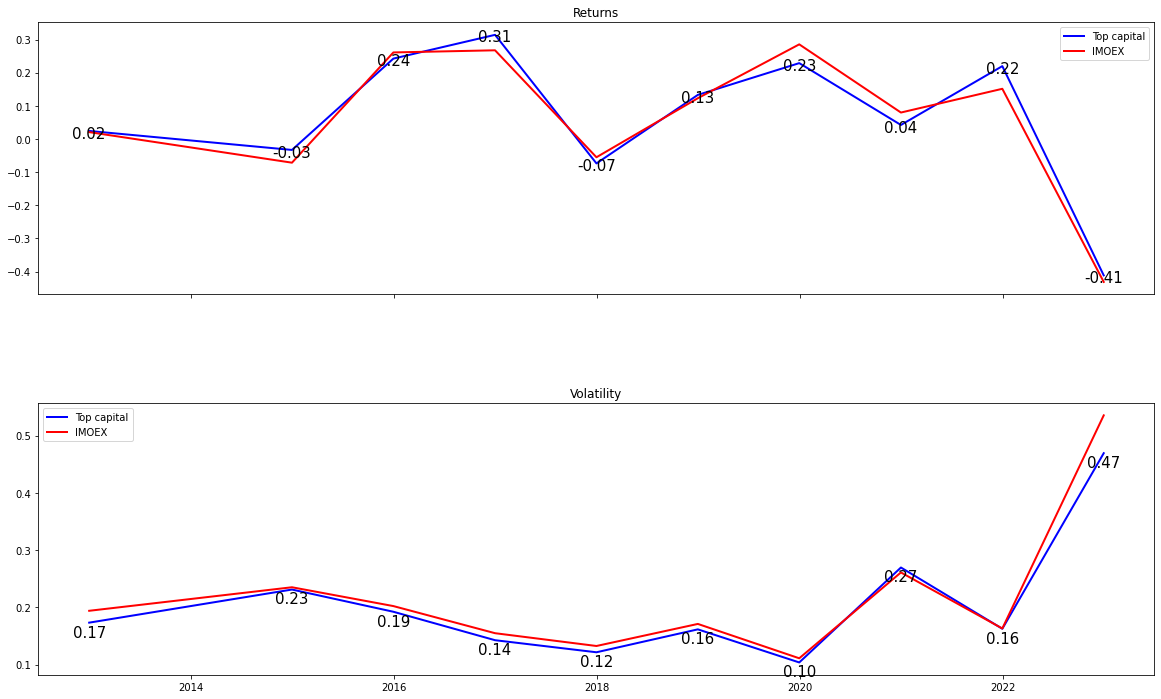

In [99]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 12), sharex=True)

# plot returns
ax1.plot(df_weighted.index, df_weighted['return'], linewidth=2.0, color = 'blue', label = 'Top capital')
ax1.plot(df_weighted.index, df_weighted['return_imoex'], linewidth=2.0, color = 'red', label = 'IMOEX')
for i, y in enumerate(df_weighted['return']):
    ax1.text(df_weighted.index[i], y - 0.03, f'{y:.2f}', ha='center', va='bottom', fontsize=15)
ax1.set_title('Returns')
ax1.legend()

# plot volatility
ax2.plot(df_weighted.index, df_weighted['volatility'], linewidth=2.0, color = 'blue', label = 'Top capital')
ax2.plot(df_weighted.index, df_weighted['volatility_imoex'], linewidth=2.0, color = 'red', label = 'IMOEX')
for i, y in enumerate(df_weighted['volatility']):
    ax2.text(df_weighted.index[i], y - 0.03, f'{y:.2f}', ha='center', va='bottom', fontsize=15)
ax2.set_title('Volatility')
ax2.legend()
# adjust layout
plt.subplots_adjust(hspace=0.4)

plt.savefig('TP_in_one_2010-2023.jpg', bbox_inches='tight', dpi = 100)

# show the plot
plt.show()


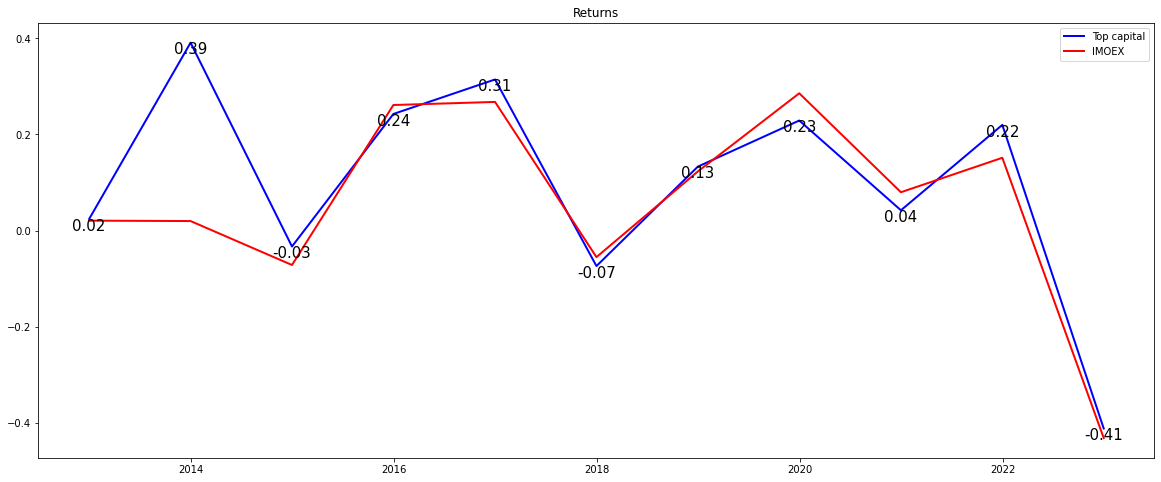

In [17]:
# Create the first plot for returns
fig1, ax1 = plt.subplots(figsize=(20, 8))
ax1.plot(df_weighted.index, df_weighted['return'], linewidth=2.0, color='blue', label='Top capital')
ax1.plot(df_weighted.index, df_weighted['return_imoex'], linewidth=2.0, color='red', label='IMOEX')
for i, y in enumerate(df_weighted['return']):
    ax1.text(df_weighted.index[i], y - 0.03, f'{y:.2f}', ha='center', va='bottom', fontsize=15)
ax1.set_title('Returns')
ax1.legend()
plt.savefig('returns_weighted_2010-2022.jpg', bbox_inches='tight', dpi=100)
plt.show()

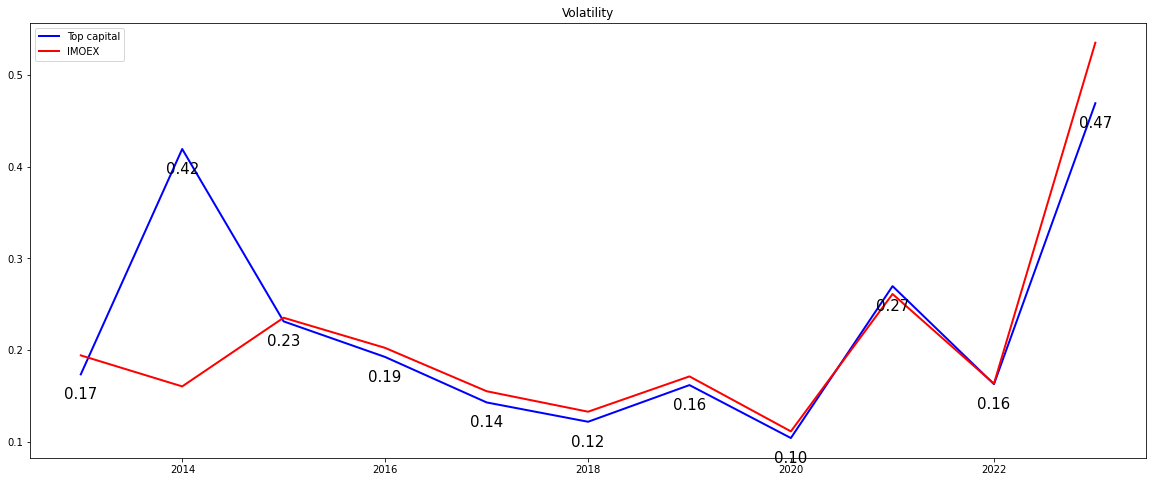

In [18]:
# Create the second plot for volatility
fig2, ax2 = plt.subplots(figsize=(20, 8))
ax2.plot(df_weighted.index, df_weighted['volatility'], linewidth=2.0, color='blue', label='Top capital')
ax2.plot(df_weighted.index, df_weighted['volatility_imoex'], linewidth=2.0, color='red', label='IMOEX')
for i, y in enumerate(df_weighted['volatility']):
    ax2.text(df_weighted.index[i], y - 0.03, f'{y:.2f}', ha='center', va='bottom', fontsize=15)
ax2.set_title('Volatility')
ax2.legend()
plt.savefig('volatility_weighted_2010-2022.jpg', bbox_inches='tight', dpi=100)
plt.show()

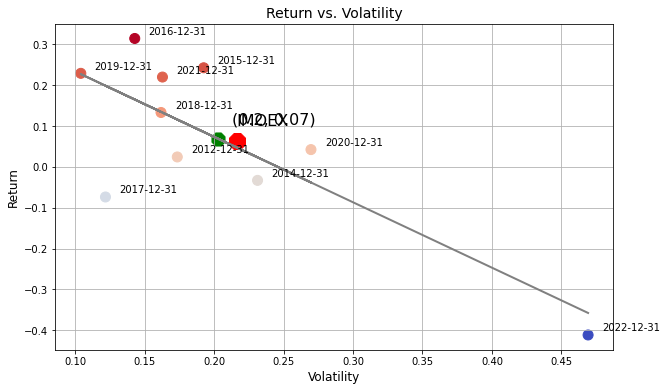

Weighted average return: 0.06872946471426344
Weighted average volatility: 0.20295250715682397


In [100]:
# Create scatter plot with text annotations and trend line
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.scatter(df_weighted['volatility'], df_weighted['return'], s=100, c=df_weighted['return'], cmap='coolwarm')
ax.scatter( df_weighted['volatility'].mean(), df_weighted['return'].mean(), color = 'green',marker = '8', s = 200)
ax.scatter(df_weighted['volatility_imoex'].mean(),df_weighted['return_imoex'].mean(), color = 'red',marker = '8', s = 300)

for i, year_range in enumerate(df_weighted.index.date):
    ax.text(df_weighted['volatility'][i] + 0.01, df_weighted['return'][i] + 0.01, year_range, fontsize=10)
z = np.polyfit(df_weighted['volatility'], df_weighted['return'], 1)
p = np.poly1d(z)
ax.plot(df_weighted['volatility'], p(df_weighted['volatility']), "-", color='gray', linewidth=2)

# Set labels and title
ax.set_xlabel('Volatility', fontsize=12)
ax.set_ylabel('Return', fontsize=12)
ax.set_title('Return vs. Volatility', fontsize=14)

ax.annotate(( df_weighted['volatility'].mean().round(2),df_weighted['return'].mean().round(2)), ( df_weighted['volatility'].mean()+ 0.01, df_weighted['return'].mean()+0.03),
            horizontalalignment='left',
            fontsize=16,
            verticalalignment='bottom')

ax.annotate(('IMOEX'), (df_weighted['volatility_imoex'].mean(), df_weighted['return_imoex'].mean()+0.03),
            horizontalalignment='left',
            fontsize=16,
            verticalalignment='bottom')

# Add colorbar
#fig.colorbar(im, ax=ax)

# Add grid
ax.grid()
plt.savefig('ret vs vol weighted.jpg', bbox_inches='tight', dpi = 100)
plt.show()
print("Weighted average return:", df_weighted['return'].mean())
print("Weighted average volatility:", df_weighted['volatility'].mean())

In [101]:
print("Weighted average return:", df_weighted['return'].mean())
print("Weighted average volatility:", df_weighted['volatility'].mean())

Weighted average return: 0.06872946471426344
Weighted average volatility: 0.20295250715682397


In [102]:
print("Weighted average return IMOEX:", df_weighted['return_imoex'].mean())
print("Weighted average volatility IMOEX:", df_weighted['volatility_imoex'].mean())

Weighted average return IMOEX: 0.06316634920983849
Weighted average volatility IMOEX: 0.21619617106201267
